In [298]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression
import os
import re

In [299]:
threshold = 1000

### Reading in from external source

In [300]:
geo = "GSE114711"
geo_data = GEOparse.get_GEO(geo=geo, destdir="../Dataset/Nigita2018", silent=True)
#table = pd.read_csv("../Dataset/Fehlman2020/expression_matrix.csv", sep="\t")
#table = pd.read_csv("../Dataset/Wozniak2015/GSE64591_non-normalized.txt", sep="\t", header=5)

In [301]:
list(geo_data.gsms.values())[-1].metadata

{'title': ['LATE STAGE rep8'],
 'geo_accession': ['GSM3148019'],
 'status': ['Public on Jun 29 2018'],
 'submission_date': ['May 21 2018'],
 'last_update_date': ['Jun 29 2018'],
 'type': ['SRA'],
 'channel_count': ['1'],
 'source_name_ch1': ['Plasma-derived exosome'],
 'organism_ch1': ['Homo sapiens'],
 'taxid_ch1': ['9606'],
 'characteristics_ch1': ['dissease state: late stage NSCLC',
  'Stage: IV',
  'Sex: Female',
  'sample type: PEV'],
 'growth_protocol_ch1': ['PEVs were isolated using the Izon qEV size exclusion column (Izon qEV, iZON science, Cambridge MA). 190uL of plasma (centrifuged for 10 minutes at 10,000xG) was added to the column membrane, followed by 310uL of PBS.  PBS was then added in 500uL increments for a total of 32 fractions. The fractions were run on a NuPAGE Bis-Tris gel to evaluate protein contamination.  Fractions 7-9 were combined as the EV fraction and fractions 12-32 were combined as the depleted fraction.  Both the EV and depleted fractions were concentrated

In [302]:
data = pd.read_csv("../Dataset/Nigita2018/Cases/GSM3147994_C1.txt", sep="\t", names=["miRNA", "value"])
data

,miRNA,value
0,hsa-let-7a-1,0
1,hsa-let-7a-1*,0
2,hsa-let-7a-2,0
3,hsa-let-7a-2*,0
4,hsa-let-7a-3,0
...,...,...
3757,hsa-mir-98*,0
3758,hsa-mir-99a,0
3759,hsa-mir-99a*,0
3760,hsa-mir-99b,5


In [303]:
cases = []
controls = []
for d in os.listdir("../Dataset/Nigita2018/Cases/"):
    pat = "[0-9]+.txt$"
    if re.search("E" + pat, d) or re.search("L" + pat, d):
        cases.append(pd.read_csv("../Dataset/Nigita2018/Cases/" + d, sep="\t", names=["miRNA", "value"]))
    if re.search("C" + pat, d):
        controls.append(pd.read_csv("../Dataset/Nigita2018/Cases/" + d, sep="\t", names=["miRNA", "value"]))

In [304]:
table = pd.concat([c.iloc[:,1] for c in controls] + [c.iloc[:,1] for c in cases], axis=1).transpose()
mirnas = cases[0].iloc[:,0]

### Seperate case and controls

In [305]:
controls = np.array(len(controls)*[1] + len(cases)*[0])
sick = 1 - controls

In [306]:
sum(controls)

7

### Drop NAN

In [307]:
table = table.apply(lambda x: 1e6 * x / x.sum(), axis=1)

In [308]:
mask = table.std() > threshold
table = table.loc[:, mask]
mirnas = mirnas[mask]

In [309]:
table = table.dropna(1)

C:\Users\olefr\AppData\Local\Temp/ipykernel_21592/1927661217.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  table = table.dropna(1)


### T-test

In [310]:
X = table

In [311]:
X_healthy, X_cancer = X[controls == 1], X[sick == 1]

In [312]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [313]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [314]:
mirnas.iloc[lowest], pvalues

(1760    hsa-mir-451a
 678      hsa-mir-29c
 184      hsa-mir-126
 562     hsa-mir-208a
 654      hsa-mir-27a
 Name: miRNA, dtype: object,
 array([0.00736405, 0.03828997, 0.03839871, 0.08745402, 0.11950505]))

### F-test

In [315]:
t3 = table

In [316]:
f, p = f_classif(t3, sick)

In [317]:
np.mean(p)

0.3827004017498824

### ANOVA

In [318]:
t3

,184,372,374,378,532,562,612,614,616,630,...,656,672,678,850,940,990,1190,1342,1760,2182
value,172797.923205,19223.501963,4666.217571,2316.678442,19338.514368,131.442748,9808.915104,5734.189902,116786.882014,20685.802540,...,3844.700393,20570.790135,16266.040123,5684.898871,4222.598295,4666.217571,262.885497,10909.748123,450750.045183,7229.351166
value,366311.668491,13027.658892,309.655729,1039.558519,4600.599405,11.059133,4279.884543,4589.540272,34382.845073,21797.551508,...,6137.818918,18888.999480,11789.035975,2455.127567,3295.621689,6591.243378,110.591332,2997.025093,423620.096657,2775.842429
value,266131.101593,19238.234346,631.624657,1783.023771,7447.907414,16632.782636,3908.177565,5849.107501,78163.551310,14211.554784,...,3598.944660,20481.745389,11112.646310,4934.567633,4335.840094,6283.349453,72.373659,7743.981472,451914.283270,4467.428564
value,260960.067969,27591.333900,1529.311810,1890.399320,5734.919286,12064.570943,1932.880204,5989.804588,74808.836024,24107.901444,...,4375.531011,24256.584537,14655.904843,11023.789295,3504.672897,14804.587935,84.961767,5437.553101,413997.451147,5586.236194
value,171137.667716,20660.943095,629.880495,1246.818241,13706.372147,103.541999,7493.852194,4499.762716,133590.750248,21006.083092,...,3369.429225,17304.456620,14405.280642,2566.978731,2446.179732,6380.775702,112.170499,5604.210708,458626.342810,7364.424695
value,234558.659160,28187.172809,488.674704,3056.816232,4569.628347,358.708027,4132.940314,4382.476333,65066.516945,12175.278259,...,4891.945705,32294.119788,15258.087826,6586.711167,2958.041558,7293.729888,228.741351,5593.765758,467074.242164,6987.008531
value,173452.961909,22095.702860,237.223804,2304.459808,6150.874339,334943.066287,2482.377660,4075.166057,73869.798021,15555.103701,...,2745.018300,19486.241019,9904.093805,4837.671140,2787.379694,8235.054900,76.250508,6811.712078,231632.099770,5227.395960
value,211765.383066,26995.913199,0.000000,1726.817475,5238.013009,57.560583,4835.088931,6101.421746,72929.258044,14562.827376,...,5640.937086,39544.120186,17095.493006,30334.426984,2705.347378,12317.964658,2129.741553,6734.588154,432510.217003,4835.088931
value,136539.692385,12022.196855,105.573628,475.081325,6994.252836,1860.735188,1339.465402,1906.923650,36462.491670,8525.070437,...,2118.070906,10141.666612,6512.573159,3747.863784,1141.514850,4341.715439,72.581869,2250.037941,698092.416514,3926.019280
value,281082.634812,17470.442277,194.444797,1293.480604,9050.137168,431.160201,5296.507180,5051.337653,50674.004844,15238.554176,...,3850.852387,19440.252609,11159.440506,2950.488437,3745.175867,3660.634651,63.405912,8306.174468,478942.896636,5660.034408


In [319]:
X = np.array(sick).reshape(-1, 1)

In [320]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [321]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted, multioutput="variance_weighted")

0.20359677967883166

### Mean-variance-plot

In [322]:
np.mean(table)

184     191543.813221
372      19784.381552
374        801.266969
378       2171.183880
532       8005.574815
562      15801.214492
612       4952.088852
614       4774.337165
616      75739.888650
630      16157.886575
632       8703.754845
642      26090.214609
654      11803.423416
656       3877.816773
672      20528.688831
678      11265.809886
850       6472.598709
940       2821.153656
990       6520.031631
1190       516.555407
1342      7087.478849
1760    509039.116794
2182      5449.173537
dtype: float64

In [323]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [324]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

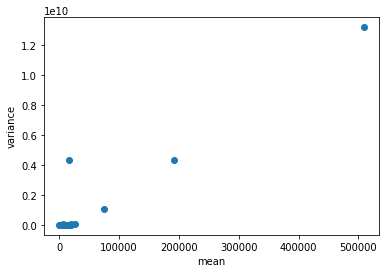

In [325]:
mean_variance_plot(table)

### Log transformation

In [326]:
log_table = np.log2(table + 1)

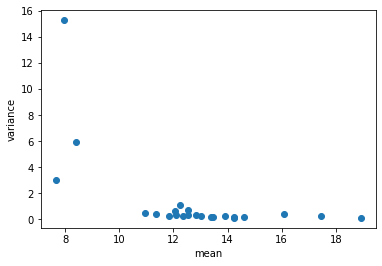

In [327]:
mean_variance_plot(log_table)

In [328]:
mask = np.mean(log_table) > 2
log_table = log_table.loc[:, mask]
mirnas = mirnas[mask]

### Loess regression

In [329]:
lowess = LowessRegression(sigma=1, span=0.1)

In [330]:
means, variances = get_means_and_variances(log_table)
lowess.fit(means.to_numpy().reshape(-1,1), variances)

LowessRegression(span=0.1)

In [331]:
x_axis = np.linspace(-2, 14, 100)
y_axis = lowess.predict(x_axis.reshape(-1,1))

[]

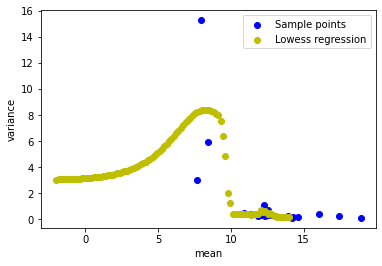

In [332]:
plt.scatter(means, variances, color="b")
plt.scatter(x_axis, y_axis, color="y")
plt.xlabel("mean")
plt.ylabel("variance")
plt.legend(["Sample points", "Lowess regression"])
plt.plot()

### Lowess normalization

In [333]:
adj_var = lowess.predict(means.to_numpy().reshape(-1, 1))

In [334]:
log_table /= np.sqrt(adj_var)

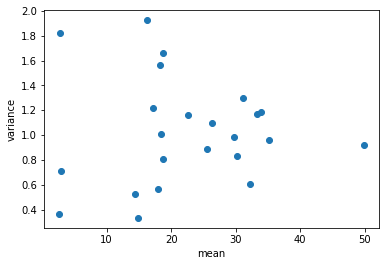

In [335]:
mean_variance_plot(log_table)

In [336]:
norm_log_table = log_table - np.mean(log_table)
norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

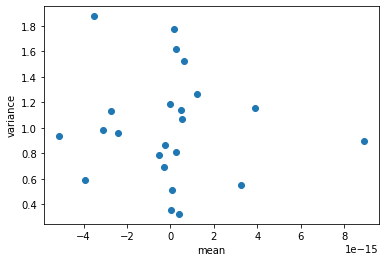

In [337]:
mean_variance_plot(norm_log_table)

### PCA

In [338]:
pca = decomposition.PCA(n_components=10)

In [339]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [340]:
pca.explained_variance_ratio_

array([0.34154107, 0.23750383, 0.09766296, 0.08112424, 0.05481895,
       0.04263752, 0.03428918, 0.02846199, 0.01693895, 0.01483314])

In [341]:
components = pca.transform(norm_log_table)

In [342]:
components.shape

(26, 10)

In [343]:
sum(controls)

7

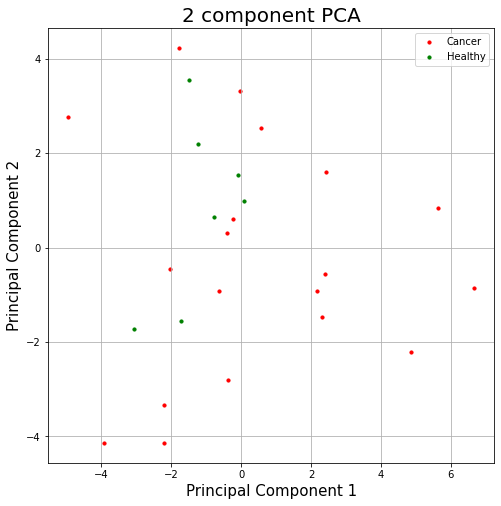

In [344]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [345]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

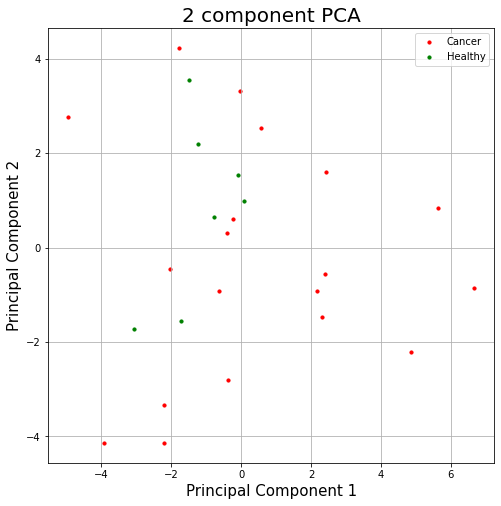

In [346]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Linear regression adjustments

In [347]:
sex = np.array(["Female" in k.metadata["characteristics_ch1"][2] for k in list(geo_data.gsms.values())])

In [348]:
sex

array([ True,  True, False, False, False,  True, False,  True,  True,
       False,  True,  True,  True, False,  True, False,  True, False,
        True,  True,  True,  True,  True, False, False,  True])

In [349]:
covars = pd.DataFrame(np.array([sex]).transpose(), columns=["sex"])

In [350]:
covars = covars.fillna(covars.mean())

In [351]:
linreg = LinearRegression()
linreg.fit(covars, norm_log_table)

LinearRegression()

In [352]:
adj_norm_log_table = norm_log_table - linreg.predict(covars)

# PCA

In [353]:
pca = decomposition.PCA(n_components=2)

In [354]:
pca.fit(adj_norm_log_table)

PCA(n_components=2)

In [355]:
components = pca.transform(adj_norm_log_table)

In [356]:
components

array([[-3.20742866, -2.41369672],
       [-0.37166133,  0.53517755],
       [-0.18767645,  1.4717362 ],
       [-1.21946107,  4.2178866 ],
       [-1.02081805, -1.05893401],
       [-1.80012391,  1.58907036],
       [ 0.48635848,  2.57111676],
       [-2.64204647,  3.41804447],
       [ 6.46071296, -0.41145971],
       [ 0.06759836, -0.21062765],
       [ 5.16610897,  0.97241787],
       [-0.45136725, -3.33306226],
       [ 1.87941251, -1.16832295],
       [ 0.06377575,  0.80492403],
       [-0.73832492, -0.08341354],
       [ 2.90917291,  0.20257966],
       [-2.2005263 , -3.99756464],
       [-1.17823682, -3.58649855],
       [-0.80142111,  2.69829288],
       [ 4.68843295, -2.18010007],
       [-5.53296437,  1.86259749],
       [-0.07229282,  2.08771153],
       [ 1.96344504,  1.55079215],
       [-2.90413776, -3.80039222],
       [ 2.98342465, -0.61179082],
       [-2.33995529, -1.12648441]])

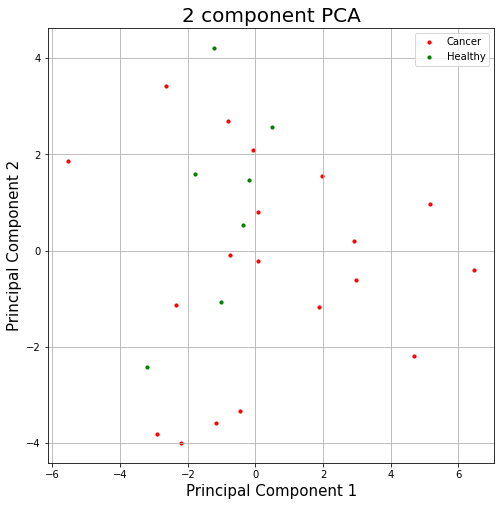

In [357]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [358]:
X_train, X_test, y_train, y_test = train_test_split(adj_norm_log_table, controls, test_size=0.33, random_state=42)

In [359]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


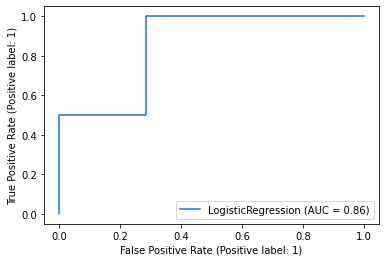

In [360]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [361]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[15:59:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


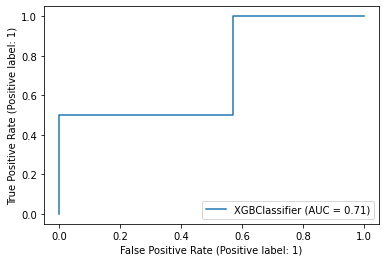

In [362]:
plot_roc_curve(model, X_test, y_test)

### Export data

In [363]:
geo_data.gpls["GPL18573"].table

""


In [364]:
mirnas = [m.replace("r", "R") for m in mirnas]

In [365]:
from Scripts import converters

In [366]:
sequences = converters.canonical_to_seq(mirnas, True)

In [367]:
sequences.count(None)

0

In [368]:
sequences = np.array(sequences)
mirnas = np.array(mirnas)

In [369]:
mask = sequences != None
adj_norm_log_table = adj_norm_log_table.loc[:, mask]
sequences = sequences[mask]

In [370]:
adj_norm_log_table.columns = sequences
adj_norm_log_table["cancer"] = sick
adj_norm_log_table.head()

,UCGUACCGUGAGUAAUAAUGCG,CAGUGGUUUUACCCUAUGGUAG,UAACACUGUCUGGUAAAGAUGG,UGAGAUGAAGCACUGUAGCUC,UGUGCAAAUCUAUGCAAAACUGA,AUAAGACGAGCAAAAAGCUUGU,AGCUACAUUGUCUGCUGGGUUUC,AGCUACAUCUGGCUACUGGGU,UGUCAGUUUGUCAAAUACCCCA,AUCACAUUGCCAGGGAUUUCC,...,UAGCACCAUCUGAAAUCGGUUA,UAGCACCAUUUGAAAUCGGUUA,GAGUUCUACAGUCAGAC,AAAAGCUGGGUUGAGAGGGCGA,UCUCACACAGAAAUCGCACCCGU,UUUGUUCGUUCGGCUCGCGUGA,AGCUCGGUCUGAGGCCCCUCAGU,AAACCGUUACCAUUACUGAGUU,UCAGGCUCAGUCCCCUCCCGAU,cancer
value,-0.094533,0.055304,1.381040,0.286272,2.724213,-0.038585,1.938178,0.541002,1.387063,1.176269,...,0.147109,1.204141,0.017502,1.344075,-0.661690,-0.103785,1.672937,-0.509741,0.731738,0
value,2.061307,-1.199291,0.050250,-1.506703,-0.876204,-1.217975,0.154005,0.165838,-1.468925,1.343163,...,-0.136973,0.171489,-1.570069,0.769292,0.073467,-0.531105,-1.078774,-0.742587,-0.913832,0
value,1.030182,-0.098996,0.160878,-0.046555,-0.347442,1.646357,-0.380569,0.330112,0.025339,-0.571371,...,0.207163,0.227974,0.426368,0.830965,0.309340,-0.131379,-0.005969,-0.087598,-0.506698,0
value,0.973883,1.063858,0.594720,0.084302,-1.002752,1.488332,-1.894856,0.370162,-0.077120,1.113436,...,0.770564,1.115784,1.946374,0.337428,2.133643,-0.052765,-0.759044,-0.416308,-0.122466,0
value,-0.236647,0.131075,0.159522,-0.846926,1.181918,-0.848727,1.019879,-0.111769,1.277191,0.674356,...,-0.354289,1.060452,-0.809316,-0.496361,0.342090,0.083768,-0.694749,-0.032296,0.352668,0


In [371]:
adj_norm_log_table.to_csv(f"../TransformedData/Nigita2018_threshold_{threshold}.csv", index=False)